In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Ellipse
import matplotlib.patches as patches
import librosa
import math
from math import pi

%run graphing_functions.ipynb

In [2]:
#Use this for all adjustable values 
#input file paths here (include .csv):
#the audio_path should contain the stimulus time.
#in server file, this is labeled at M1

video_path = r'\\10.25.16.5\yaochen\Active\DLC\Final_Models\Hanna\escape_behavior_HannaJachna_2024-07-8\drd1ReRuns\coords_csv\Coordmouse4359_control_videoAVI_P2DLC_resnet50_escape_behavior_2Jun13shuffle1_1030000_filtered_day.csv'
time_path = r'\\10.25.16.5\yaochen\Active\Hanna\Escape_behavior\control_pki_drd1Cre_rerun_mostMostRecent\videoTimestamp\mouse4359_control_videoTimestamp_P20.csv'
audio_path = r'\\10.25.16.5\yaochen\Active\Hanna\Escape_behavior\control_pki_drd1Cre_rerun_mostMostRecent\stimulusTimestamp\mouse4359_control_stimulusTimestamp_P20.csv'

north_pixel = 51
south_pixel = 473
east_pixel = 541
west_pixel = 88
shelter_x_pixel = 120
shelter_y_pixel = 318

#estimate for when mouse reaches shelter
escape_estimate = 10 #time mouse reaches shelter location

#set sigma for gaussian filter - look into how to decide 
sigma = 2

#stimulus of choice:
stimulus = 1

In [3]:
#manually decide?
freezing_response = False

#does the mouse turn its head in the shortest angle to shelter
small_angle = True

In [4]:
#read in DLC data (video_path), convert all points to cm, and center platform at 0,0
#return converted coordinates for all in dataframe called coords, return new coordinates for the shelter and the x and y diam
#parameters: N, S, E, W, shelter_x, shelter_y, video path (pixel information and DLC data defined in cell 2)
shelter_x, shelter_y, x_diam, y_diam, coords = single_mouse_data(north_pixel, south_pixel, east_pixel, west_pixel, shelter_x_pixel, shelter_y_pixel, video_path)

In [5]:
#replace any mouse skeleton points with likelihood < .9 with NA (stored in coords)
#coords dataframe is filled with NA when LT<.9, coords_scaled has interpolated data for NA values
#returns new df (coord_scaled) with low threshold values interpolated

#parameters: likelihood threshold and dataframe with DLC data
coord_scaled = filter_data(.9, coords)

In [6]:
#add column for time in seconds for both coords (na values) and coord_scaled (interpolated). stimulus at 0s.
#choose which stimulus to look at - 1 or 2 

#parameters: path to bonsai video timestamps, dataframe, audio path (stimulus timestamps from bonsai), which stimulus you want to look at
convert_time(time_path, coords, audio_path, stimulus)
convert_time(time_path, coord_scaled, audio_path, stimulus)

In [7]:
#adds 3 new columns: 1 is an average of all points to use instead of the center of the mouse, another is averaged upper body (spine1, center) and the last is averaged head (nose, head, ears)
#more robust to use average of multiple points vs a single variable point (esp when looking at head angle bc of nose)

#parameters: dataframe
average_points(coords)
average_points(coord_scaled)

In [8]:
#calculate displacement as 'displacement'

#parameters: converted shelter_x, converted shelter_y, dataframe
displacement(shelter_x, shelter_y, coords) 
displacement(shelter_x, shelter_y, coord_scaled) 

In [9]:
#calculate speed as 'speed' and change in displacement as 'delta_vector' (use delta vector for linearity calculations)

#parameters: dataframe
total_distance = speed(coord_scaled) 
total_distance_coords = speed(coords) 

In [10]:
#calculate head angle as 'head_angle'

#parameters: converted shelter_x, converted shelter_y, dataframe
angle(shelter_x, shelter_y, coord_scaled) 
angle(shelter_x, shelter_y, coords) 

In [11]:
#calculate head angle speed as 'angle_speed'
#haven't assessed

#parameters: dataframe
angle_speed(coord_scaled) 
angle_speed(coords) 

In [12]:
#determines more precise time for escape - either when mouse reaches shelter border OR gets closest

#parameters: converted shelter x, converted shelter y, estimate for shelter reaching time, dataframe
escape_done = escape_timeframe(shelter_x, shelter_y, escape_estimate, coord_scaled)
#below I am replacing escape estimate with 7 seconds

In [13]:
#finds linearity ratio 

#parameters: shelter reaching time found in cell 12, dataframe
ratio, initial_displacement, total_distance = linearity_ratio(0, escape_done, coord_scaled)

In [14]:
#determine whether response is classified as an escape - look at time, linearity, and shelter reach

#parameters: shelter reaching time, converted shelter x, converted shelter y, dataframe, desired percent shelter expansion, time, linearity cutoffs
#escape = escape_response(escape_done, shelter_x, shelter_y, coord_scaled, 30, 12, 1.3)
#note: the last value in the above function is setting the linearity ratio to 1.3
#print(escape)

In [15]:
#can edit code to use this dataframe in above graphs, have this defined to pass into compiled mice. Apply filter to displacement, speed, angle, angle speed (angle speed not accurate)

#parameter: sigma, dataframe
coord_scaled_smooth = smooth_curve(sigma, coord_scaled)

Mouse reaches prior shelter location 6.6811130000060075 seconds after stimulus start time.
The displacement of the mouse from the stimulus onset to when it reaches the shelter is 41.523553508854825 cm.
The total distance that the mouse travels during the stimulus time is  61.91984542873195 cm.
Mouse reaches point closest to prior shelter location with a linearity ratio of 1.4911981320560066.


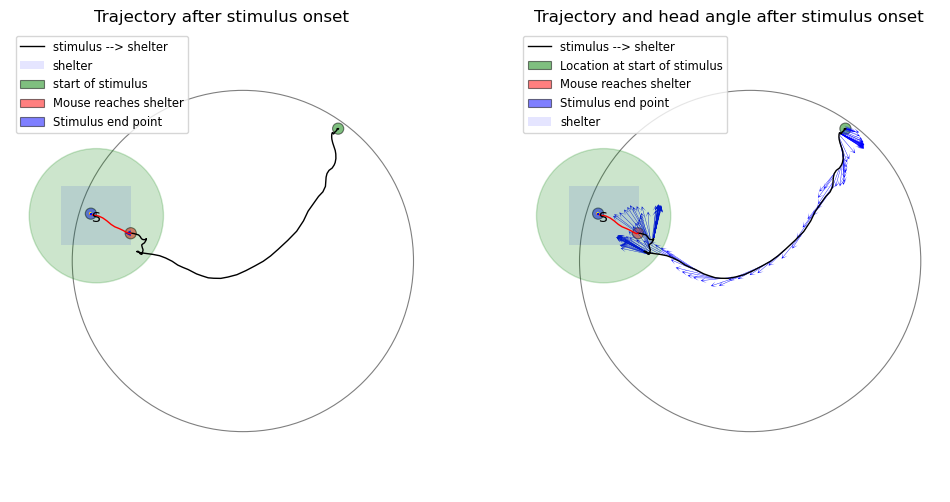

In [27]:
#parameters: converted shelter x, converted shelter y, converted x diameter, converted y diameter, start time, stop time, dataframe
#if moves away from shelter or freezes use escape estimate or you get an empty df 

trajectories(shelter_x, shelter_y, x_diam, y_diam,0, escape_done, coord_scaled)
print("Mouse reaches prior shelter location " + str(escape_done) + " seconds after stimulus start time.")
print("The displacement of the mouse from the stimulus onset to when it reaches the shelter is " + str(initial_displacement) + " cm.") 
print("The total distance that the mouse travels during the stimulus time is  " + str(total_distance) + " cm.") 
print("Mouse reaches point closest to prior shelter location with a linearity ratio of " + str(ratio) + ".") 

<module 'matplotlib.pyplot' from 'C:\\anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

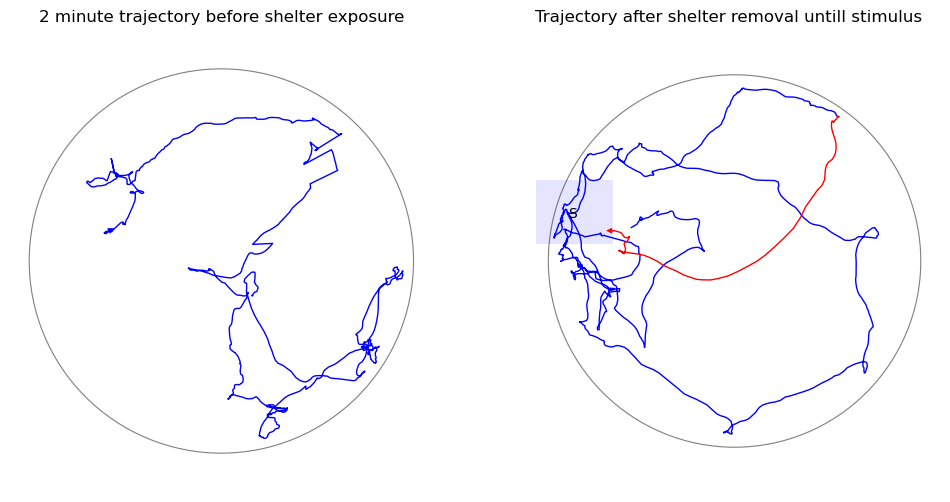

In [17]:
#trajectory for 2 minutes of start of P2 video, trajectory 1 minute before and through escape
#parameters: converted shelter x, converted shelter y, converted x diam, converted y diam, shelter reaching time, dataframe
#if moves away from shelter or freezes use escape estimate or you get an empty df 

before_shelter_trajectory(shelter_x, shelter_y, x_diam, y_diam, escape_done, coord_scaled)

<module 'matplotlib.pyplot' from 'C:\\anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

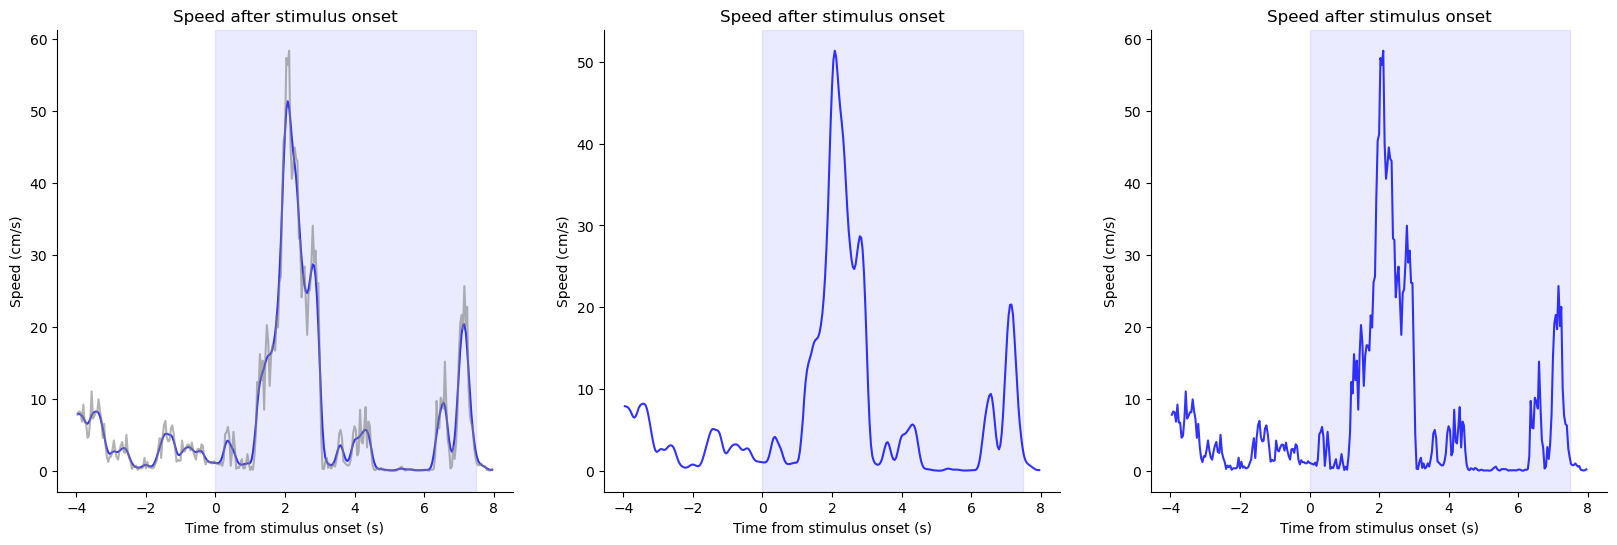

In [18]:
#plot intermediate steps - raw and with gaussian filter

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

#parameters: ax, start time, stop time, dataframe, apply filter?, overlay filter and raw?, for vertical alignment? (includ labels or not), sigma value
speed_figure(ax1, -4, 8, coord_scaled, False, True, False, sigma)
speed_figure(ax2, -4, 8, coord_scaled, True, False, False,sigma)
speed_figure(ax3, -4, 8, coord_scaled, False, False, False,sigma)

<module 'matplotlib.pyplot' from 'C:\\anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

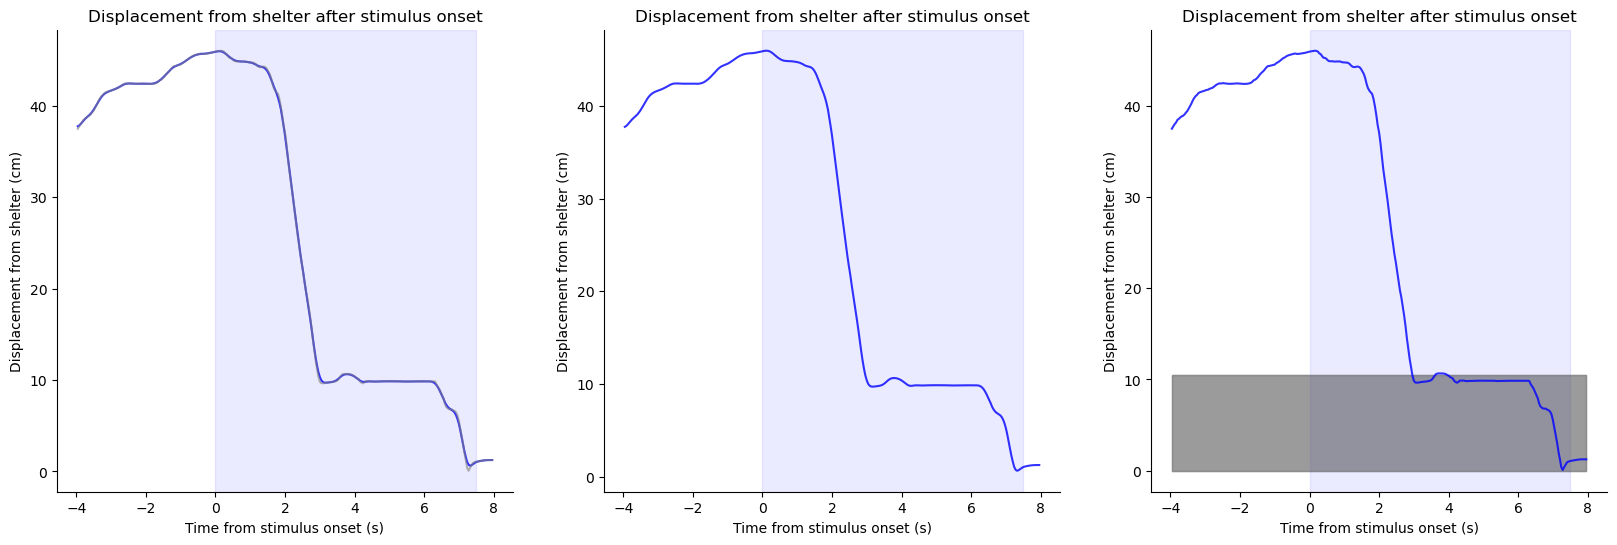

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

displacement_figure(ax1, -4, 8, coord_scaled, False, True, False,sigma)
displacement_figure(ax2, -4, 8, coord_scaled, True, False, False,sigma)
displacement_figure(ax3, -4, 8, coord_scaled, False, False, False,sigma)


<module 'matplotlib.pyplot' from 'C:\\anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

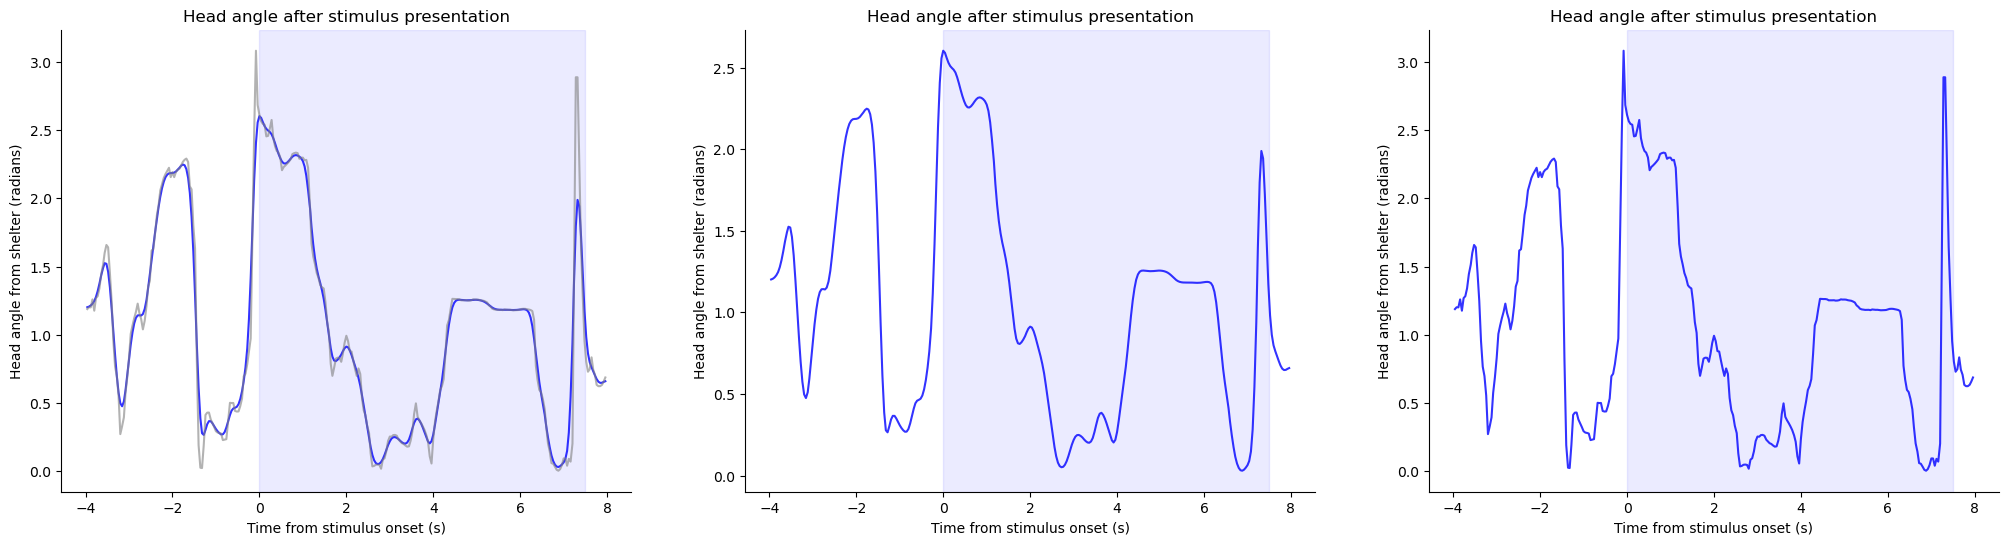

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 6))

head_angle_figure(ax1, -4, 8, coord_scaled, False, True, False,sigma)
head_angle_figure(ax2, -4, 8, coord_scaled, True, False, False,sigma)
head_angle_figure(ax3, -4, 8, coord_scaled, False, False,False, sigma)

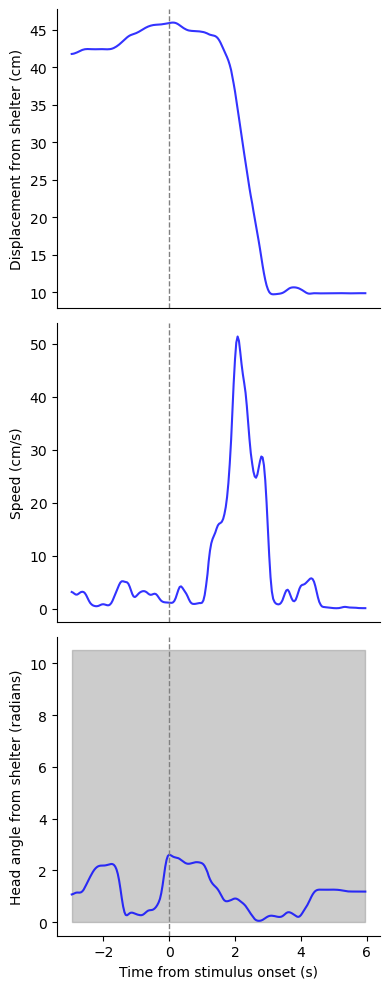

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize = (4,10))

displacement_figure(ax1, -3, 6, coord_scaled, True, False, True, sigma)
speed_figure(ax2, -3, 6, coord_scaled, True, False, True, sigma)
head_angle_figure(ax3, -3, 6, coord_scaled, True, False, True, sigma)

plt.tight_layout()

<module 'matplotlib.pyplot' from 'C:\\anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

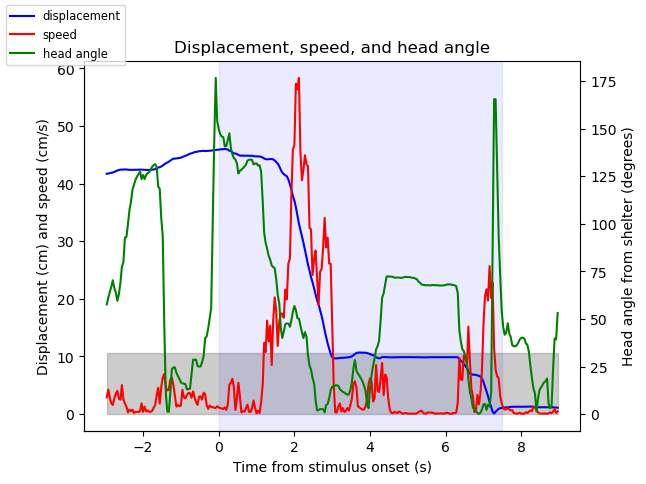

In [22]:
#normalized overlay of displacement, speed, head angle
#parameters: start time, stop time, dataframe
combined_graphs(-3, 9, coord_scaled)

In [23]:
likelihood_data, likelihood_minus_nose, likelihood_center = likelihood_check(0, 8, .9, coords)

In [24]:
#new dataframe (rotate) with rotated coordinates and shelter at 0, 25

#parameters: converted shelter x, converted shelter y, start time, stop time, dataframe
#if moves away from shelter or freezes use escape estimate or you get an empty df 

rotate, shelter_rotate_x, shelter_rotate_y = align_shelter(shelter_x, shelter_y, 0, escape_done, coord_scaled)

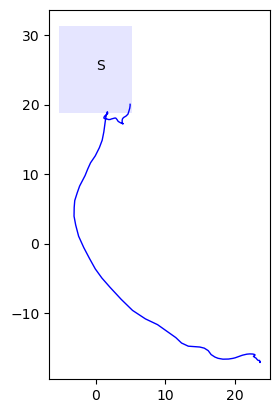

In [25]:
#visualize rotation above 
fig = plt.figure()  #create figure to fill in
ax = plt.axes()
    
    #make x and y scales equal - present as a circle


    #plot the center x and y coordinates
x = rotate['rotated_x']
y = rotate['rotated_y']

ax.text(shelter_rotate_x,shelter_rotate_y, 'S', color = 'black', size = 10)
shelter = patches.Rectangle(((shelter_rotate_x - 5.25), (shelter_rotate_y-6.25)), 10.5,12.5,  linewidth = .8, edgecolor = 'none', facecolor = 'blue', alpha = .1)
ax.add_patch(shelter)

ax.set_aspect('equal')
ax.plot(x,y, color = 'blue', linewidth = 1)


In [26]:
#try plotting all of P1s trajectory 